# 𝔻𝕖𝕔𝕖𝕟𝕥ℕ𝕖𝕥: 𝕕𝕚𝕤𝕖𝕟𝕥𝕒𝕟𝕘𝕝𝕖𝕕 𝕟𝕖𝕥

Goal: create a sparse and modular ConvNet

Todos: 
* [ ] delete node (filter) if either no input or no output edges
* [ ] AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
* [ ] cuda error, if one of the decent1x1 has no kernels left - we need at least one input for each 1x1 filter
* [ ] can we keep training if filter gets removed (e.g. at reloading model)
* [ ] need some working filter removing in general - only at reload rn


Notes:
* additionally needed: position, activated channels, connection between channels
* within this layer, a whole filter can be deactivated
* within a filter, single channels can be deactivated
* within this layer, filters can be swapped
* the 'value' in the csv file is random if the CI metric is 'random'
     
* pruning actually doesn't work: https://discuss.pytorch.org/t/pruning-doesnt-affect-speed-nor-memory-for-resnet-101/75814   
* fine tune a pruned model: https://stackoverflow.com/questions/73103144/how-to-fine-tune-the-pruned-model-in-pytorch
* an actual pruning mechanism: https://arxiv.org/pdf/2002.08258.pdf

pip install:
* pytorch_lightning

preprocessing possible:
* flatten layers
* denoise
* crop background


warnings:
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
C:\Users\Christina\anaconda3\envs\chrisy\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned_state', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.

![uml of code](examples/example_vis/uml.png)

# conventions

* entry image: entry_id5_0_0_0_mo3_gt2.png
* hidden layer: hid_id5_3_8_2.png
* last layer (global pooling - connected to class n): pool_2_3_4_gp2.png
* activated image: cam_id5_mo3_gt2.png
* activated image gray: camgray_id5_mo3_gt2.png


* circle in: in_2_3_4_ep65.png
* circle out: out_2_3_4_ep65.png

# imports

In [2]:
# =============================================================================
# sys
# =============================================================================
import sys 
sys.path.insert(0, "helper")
# =============================================================================
# alphabetic order misc
# =============================================================================
from __future__ import print_function
import math
import matplotlib.pyplot as plt
plt.ioff()
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
# from sklearn.model_selection import train_test_split
import warnings
# =============================================================================
# torch
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
# import torchvision
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# from pytorch_lightning.callbacks.model_checkpoint import *
# =============================================================================
# datasceyence
# =============================================================================
from helper.model.decentnet import DecentNet
from helper.visualisation import feature_map
from helper.data.mnist import DataMNIST
from helper.data.retinamnist import DataRetinaMNIST
from helper.data.octmnist import DataOCTMNIST
from helper.data.octa500 import DataOCTA500
from helper.data.organmnist3D import DataOrganMNIST3D

In [3]:
seed = 1997 # was 19 before

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

print("cuda available:", torch.cuda.is_available())

debug_model = False

print('torch 2.0.0 ==', torch.__version__=='2.0.0')
print('tl 2.1.0 ==', pl.__version__=='2.1.0')

cuda available: True
torch 2.0.0 == False
tl 2.1.0 == True


# Settings

In [11]:
model_kwargs = {
    'in_channels' : 1, # not in use yet
    'n_classes': None, # filled in the dataset
    'out_dim' :  [1, 4, 8, 8], # [1, 8, 16, 32], #[1, 16, 24, 32] # entry, decent1, decent2, decent3
    'grid_size' : 18*18,
    'criterion': torch.nn.CrossEntropyLoss(),# torch.nn.BCEWithLogitsLoss(),
    'optimizer': "sgd", # sgd adamw
    'base_lr': 0.001,
    'min_lr' : 0.00001,
    'momentum' : 0.9,
    'lr_update' : 100,
    # decentnet
    'cc_weight': 10,
    'cc_metric' : 'l2', # connection cost metric (for loss) - distance metric
    'ci_metric' : 'l2', # channel importance metric (for pruning)
    'cm_metric' : 'not implemented yet', # 'count', # crossing minimisation 
    'update_every_nth_epoch' : 1, # 5
    'pretrain_epochs' : 1, # 20
    'prune_keep' : 0.7, # 0.97, # in each epoch
    'prune_keep_total' : 0.4, # this number is not exact, depends on the prune_keep value
}

train_kwargs = {
    'result_path': "examples/example_results", # "example_results/lightning_logs", # not in use??
    'exp_name': "debug_retinamnist_no_fc", # must include dataset name, otherwise mnist is used
    'load_ckpt_file' : 'version_18/checkpoints/epoch=4-unpruned=192-val_f1=0.12.ckpt', # "version_0/checkpoints/epoch=94-unpruned=1600-val_f1=0.67.ckpt", # 'version_94/checkpoints/epoch=26-step=1080.ckpt', # change this for loading a file and using "test", if you want training, keep None
    'epochs': 3, # including the pretrain epochs - no adding up
    'img_size' : 28, #168, # keep mnist at original size, training didn't work when i increased the size ... # MNIST/MedMNIST 28 × 28 Pixel
    'batch_size': 2, # 128, # the higher the batch_size the faster the training - every iteration adds A LOT OF comp cost
    'log_every_n_steps' : 4, # lightning default: 50 # needs to be bigger than the amount of steps in an epoch (based on trainset size and batchsize)
    'device': "cuda",
    'num_workers' : 0, # 18, # 18 for computer, 0 for laptop
    'train_size' : (2 * 4), # total or percentage
    'val_size' : (2 * 4), # total or percentage
    'test_size' : 8, # total or percentage - 0 for all
}

print("train kwargs", train_kwargs)
print("model kwargs", model_kwargs)

kwargs = {'train_kwargs':train_kwargs, 'model_kwargs':model_kwargs}

train kwargs {'result_path': 'examples/example_results', 'exp_name': 'debug_retinamnist_no_fc', 'load_ckpt_file': 'version_18/checkpoints/epoch=4-unpruned=192-val_f1=0.12.ckpt', 'epochs': 3, 'img_size': 28, 'batch_size': 2, 'log_every_n_steps': 4, 'device': 'cuda', 'num_workers': 0, 'train_size': 8, 'val_size': 8, 'test_size': 8}
model kwargs {'in_channels': 1, 'n_classes': None, 'out_dim': [1, 4, 8, 8], 'grid_size': 324, 'criterion': CrossEntropyLoss(), 'optimizer': 'sgd', 'base_lr': 0.001, 'min_lr': 1e-05, 'momentum': 0.9, 'lr_update': 100, 'cc_weight': 10, 'cc_metric': 'l2', 'ci_metric': 'l2', 'cm_metric': 'not implemented yet', 'update_every_nth_epoch': 1, 'pretrain_epochs': 1, 'prune_keep': 0.7, 'prune_keep_total': 0.4}


## check the values

In [12]:
breaking = 6000*model_kwargs['prune_keep_total']
weights = 6000 # this value is an estimate for a model [1, 8, 16, 32]
# 'unpruned' is the logger variable for the value

for i in range(train_kwargs['epochs']):
    
    if (weights < breaking): # weights*model_kwargs['prune_keep']
        print("stop:", breaking)
        print('you need at least this many epochs:', i)
        print('you currently have this many epochs:', train_kwargs['epochs'])
        print("recommended to add 2*update_every_nth_epoch")
        break
    
    # not sure whether -1 is correct, have to check
    if i > model_kwargs['pretrain_epochs'] and ((i-1)%model_kwargs['update_every_nth_epoch'] == 0):
        weights = int(weights*model_kwargs['prune_keep'])
    
        print(i, weights)
    

2 4200


# Data

## Dataset
* the dataset name needs to be part of the experiment name

In [13]:
if 'octmnist' in train_kwargs['exp_name']:
    # OCTMINST
    data = DataOCTMNIST(train_kwargs, model_kwargs)   
elif 'retinamnist' in train_kwargs['exp_name']:
    # RetinaMNIST
    data = DataRetinaMNIST(train_kwargs, model_kwargs)
elif 'octa500' in train_kwargs['exp_name']:
    # OCTA-500
    data = DataOCT500(train_kwargs, model_kwargs)
elif '3d' in train_kwargs['exp_name']:
    data = DataOrganMNIST3D(train_kwargs, model_kwargs)
else:
    # MNIST
    data = DataMNIST(train_kwargs, model_kwargs)

assert model_kwargs['n_classes'] != None, "DECENT ERROR: make sure you set the n_classes with the dataset"  
print("n_classes:", model_kwargs['n_classes'])

Using downloaded and verified file: C:\Users\Christina\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\Christina\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\Christina\.medmnist\retinamnist.npz
python_class : RetinaMNIST
description : The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
url : https://zenodo.org/record/6496656/files/retinamnist.npz?download=1
MD5 : bd4c0672f1bba3e3a89f0e4e876791e4
task : ordinal-regression
label : {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
n_channels : 3
n_samples : {'train': 1080, 'val': 120, 'test': 400}
license : CC BY 4.0
n_classes: 5


## X (Datatype)

In [14]:
class X:
    # =============================================================================
    #
    # an object with image representations and their positions
    # amout of channels need to have same length as m and n lists
    #
    # =============================================================================
    
    def __init__(self, data, ms_x, ns_x):
        self.data = data # list of tensors (image representations)
        self.ms_x = ms_x # list of integers (m position of each image representation)
        self.ns_x = ns_x # list of integers (n position of each image representation)
                
    def setter(self, data, ms_x, ns_x):
        self.data = data
        self.ms_x = ms_x
        self.ns_x = ns_x
        
    def getter(self):
        return self.data, self.m, self.n
    
    def __str__(self):
        return 'X(data: ' + str(self.data.shape) +' at positions: ms_x= ' + ', '.join(str(m.item()) for m in self.ms_x) + ', ns_x= ' + ', '.join(str(n.item()) for n in self.ns_x) + ')'
    __repr__ = __str__

  

# Lightning

## Callbacks

In [15]:
class DecentModelCheckpoint(ModelCheckpoint):

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        # =============================================================================
        # costum model checkpoint
        # Save a checkpoint at the end of the training epoch.
        # parameters:
        #    trainer
        #    module
        # saves:
        #    the checkpoint model
        # sources:
        #    https://github.com/Lightning-AI/pytorch-lightning/blob/master/src/lightning/pytorch/callbacks/model_checkpoint.py
        # =============================================================================
        
        if (
            not self._should_skip_saving_checkpoint(trainer) 
            and self._should_save_on_train_epoch_end(trainer)
        ):
            monitor_candidates = self._monitor_candidates(trainer)
            monitor_candidates["epoch"] = monitor_candidates["epoch"]
            print("DECENT NOTE: callback on_train_epoch_end", monitor_candidates["epoch"].item())
            if monitor_candidates["epoch"] > 0:
                if monitor_candidates["unpruned_state"] != -1:
                    print("DECENT NOTE: save model", monitor_candidates["epoch"].item())
                    if self._every_n_epochs >= 1 and ((trainer.current_epoch + 1) % self._every_n_epochs) == 0:
                        self._save_topk_checkpoint(trainer, monitor_candidates)
                    self._save_last_checkpoint(trainer, monitor_candidates)
                    
                    pl_module.model.get_everything(current_epoch=trainer.current_epoch)


## LightningModule

In [16]:
class DecentLightning(pl.LightningModule):
    # =============================================================================
    #
    # Lightning Module consists of functions that define the training routine
    # train, val, test: before epoch, step, after epoch, ...
    # https://github.com/Lightning-AI/pytorch-lightning/blob/master/src/lightning/pytorch/core/module.py
    # order for the instance methods:
    # https://pytorch-lightning.readthedocs.io/en/1.7.2/common/lightning_module.html#hooks
    # 
    # =============================================================================

    def __init__(self, kwargs, log_dir):
        super().__init__()
        
        # print("the kwargs: ", kwargs)
        
        # keep kwargs for saving hyperparameters
        model_kwargs = kwargs['model_kwargs']
        
        self.log_dir = log_dir
        
        if train_kwargs["load_ckpt_file"] != '':
            self.ckpt_path = os.path.join(log_dir, train_kwargs["load_ckpt_file"])
            if os.path.isfile(ckpt_path):
                print(f"Found pretrained model at {ckpt_path}, loading...")
                self.model = DecentNet(model_kwargs=model_kwargs, log_dir=log_dir, ckpt_path=ckpt_path).to("cuda")
            else:
                # n_classes=self.n_classes, grid_size=self.grid_size, out_dim=self.out_dim, prune_keep=self.prune_keep, prune_keep_total=self.prune_keep_total, cc_metric=self.cc_metric
                self.model = DecentNet(model_kwargs=model_kwargs, log_dir=log_dir).to("cuda")
        else:
            # n_classes=self.n_classes, grid_size=self.grid_size, out_dim=self.out_dim, prune_keep=self.prune_keep, prune_keep_total=self.prune_keep_total, cc_metric=self.cc_metric
            self.model = DecentNet(model_kwargs=model_kwargs, log_dir=log_dir).to("cuda")
            
        # print(self.model)
        
        self.n_classes = model_kwargs["n_classes"]
        self.cc_weight = model_kwargs["cc_weight"]
        self.criterion = model_kwargs["criterion"]
        self.optimizer = model_kwargs["optimizer"]
        self.base_lr = model_kwargs["base_lr"]
        self.min_lr = model_kwargs["min_lr"]
        self.lr_update = model_kwargs["lr_update"]
        self.momentum = model_kwargs["momentum"]
        self.update_every_nth_epoch = model_kwargs["update_every_nth_epoch"]
        self.pretrain_epochs = model_kwargs["pretrain_epochs"]
        
        # needed for hparams.yaml file
        self.save_hyperparameters()
        
        if False:
            self.metric = { "train_acc" : torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes),
                         "train_f1" : torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes),
                         "val_acc" : torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes),
                         "val_f1" : torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
                       }
        else:
            self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
            self.train_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
            self.train_prec =  torchmetrics.Precision(task="multiclass", average='macro', num_classes=self.n_classes)
            
            self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
            self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
            self.val_prec =  torchmetrics.Precision(task="multiclass", average='macro', num_classes=self.n_classes)
            
            self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.n_classes)
            self.test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=self.n_classes)
            self.test_prec =  torchmetrics.Precision(task="multiclass", average='macro', num_classes=self.n_classes)

            
    def forward(self, x, mode="grad"):
        # =============================================================================
        # we make it possible to use model_output = self(image)
        # =============================================================================
        return self.model(x, mode)
    
    def configure_optimizers(self):
        # =============================================================================
        # returns:
        #    optimiser and lr scheduler
        # =============================================================================  
        print("DECENT NOTE: configure_optimizers")
        
        if self.optimizer == "adamw":
            optimiser = optim.AdamW(self.parameters(), lr=self.base_lr)
            lr_scheduler = optim.lr_scheduler.MultiStepLR(optimiser, milestones=[50,100], gamma=0.1)
            return [optimiser], [lr_scheduler]
        else:
            optimiser = optim.SGD(self.parameters(), lr=self.base_lr, momentum=self.momentum)
            lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser, 
                                                                              T_0 = self.lr_update, # number of iterations for the first restart.
                                                                              eta_min = self.min_lr
                                                                               )
            return [optimiser], [lr_scheduler]
        
    def on_train_epoch_start(self):
        # =============================================================================
        # initial plot of circular layer
        # updates model every nth epoch
        # =============================================================================  
        print("DECENT NOTE: on_train_epoch_start", self.current_epoch)
        
        # plot random layer (the circular plot)
        if self.current_epoch == 0:
            self.model.plot_incoming_connections(current_epoch=0)
            self.model.plot_outgoing_connections(current_epoch=0)

        # update model
         # don't update unless pretrain epochs is reached
        if (self.current_epoch % self.update_every_nth_epoch) == 0 and self.current_epoch >= self.pretrain_epochs:
            print("DECENT NOTE: update model", self.current_epoch)        
            if debug_model:
                print("DECENT NOTE: before update")
                print("DECENT NOTE: print model ...")
                print(self.model)
            self.model.update(current_epoch = self.current_epoch)
            if True: 
                print("DECENT NOTE: after update")
                print("DECENT NOTE: print model ...")
                print(self.model)
                
            print("DECENT NOTE: model updated")

    def training_step(self, batch, batch_idx):
        # =============================================================================
        # calculates loss for a batch # 1
        # parameters:
        #    batch
        #    batch id
        # returns:
        #    loss
        # notes:
        #    calling gradcam like self.gradcam(batch) is dangerous cause changes gradients
        # =============================================================================     
        if False: # batch_idx < 2: # print first two steps
            print("DECENT NOTE: training_step", batch_idx)

        # calculate loss
        # loss = torch.tensor(1)
        loss = self.run_loss_n_metrics(batch, mode="train")
        
        return loss

    def validation_step(self, batch, batch_idx):
        # =============================================================================
        # calculate loss for logging # 2
        # =============================================================================
        if False: # batch_idx < 2:
            print("DECENT NOTE: validation_step", batch_idx)
        
        self.run_loss_n_metrics(batch, mode="val")
        
    def on_validation_epoch_end(self):
        # =============================================================================
        # currently nothing # 3
        # =============================================================================
        print("DECENT NOTE: on_validation_epoch_end")
        pass
    
    def on_train_epoch_end(self):
        # =============================================================================
        # save model if next iteration model is pruned # 4 
        # this needs to be called before callback 
        # - if internal pytorch lightning convention changes, this will stop working
        # =============================================================================
        print("DECENT NOTE: on_train_epoch_end", self.current_epoch)
               
        if False:
            print("current epoch")
            print(((self.current_epoch+1) % self.update_every_nth_epoch) == 0)
            print(self.current_epoch+1)
            print(self.current_epoch)
            print(self.update_every_nth_epoch)
        
        # numel: returns the total number of elements in the input tensor
        unpruned = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.log(f'unpruned', unpruned, on_step=False, on_epoch=True) 
        
        if ((self.current_epoch+1) % self.update_every_nth_epoch) == 0 and self.current_epoch != 0:
            # if next epoch is an update, set unpruned flag            
            self.log(f'unpruned_state', 1, on_step=False, on_epoch=True)
            
            # save file
            with open(os.path.join(self.log_dir, 'logger.txt'), 'a') as f:
                f.write("\n# parameter requires grad shape #\n")
                for p in self.model.parameters():
                    if p.requires_grad:
                        f.write(str(p.shape))
            
        else:
            # else set unpruned flag to -1, then model won't be saved
            self.log(f'unpruned_state', -1, on_step=False, on_epoch=True)

    def on_test_epoch_start(self):
        self.model.get_everything(current_epoch='final_test')
        
        
        
        
    def test_step(self, batch, batch_idx):
        # =============================================================================
        # calculate loss for logging, plot gradcam
        # =============================================================================
        if batch_idx < 2:
            print("DECENT NOTE: test_step", batch_idx)

        self.run_loss_n_metrics(batch, mode="test")

        """
        with torch.enable_grad():
            grad_preds = preds.requires_grad_()
            preds2 = self.layer2(grad_preds)

        """
        
        
        # save image
        
        img, _ = batch
        
        print(img.shape)
        
        tmp_file_name = f'entry_id{batch_idx}_{0}_{0}_{0}_mo{self.mo}_gt{self.gt}.png'
        # tmp_img = self.feature_maps.squeeze()[i_map].cpu().detach().numpy()
        
        tmp_img = img.squeeze().cpu().detach().numpy()
        
        plt.imsave(os.path.join(self.log_dir, tmp_file_name), tmp_img)
        
        
        # save feature maps of hidden layers and the layer that gets globally pooled
        try:
            with torch.set_grad_enabled(True): # torch.set_grad_enabled(True):
                self.run_xai_gradcam(batch, batch_idx, mode='explain')
        except Exception as e:
            print("DECENT EXCEPTION: batch size has to be 1")
            print(e)
            
        with torch.set_grad_enabled(True):
            
            layer = self.model.decent1
            # this line seems to be useless, always same output no matter what
            layer_str = 'decent1' # 'decent3'  model.model.decent3' # .filter_list[7]weights
            self.run_xai_feature_map(batch, batch_idx, layer, layer_str, device='cuda')
            
            layer = self.model.decent2
            # this line seems to be useless, always same output no matter what
            layer_str = 'decent2' # 'decent3'  model.model.decent3' # .filter_list[7]weights
            self.run_xai_feature_map(batch, batch_idx, layer, layer_str, device='cuda')
            
            layer = self.model.decent3
            # this line seems to be useless, always same output no matter what
            layer_str = 'decent3' # 'decent3'  model.model.decent3' # .filter_list[7]weights
            self.run_xai_feature_map(batch, batch_idx, layer, layer_str, device='cuda')
            
            layer = self.model.decent1x1
            # this line seems to be useless, always same output no matter what
            layer_str = 'decent1x1' # 'decent3'  model.model.decent3' # .filter_list[7]weights
            self.run_xai_feature_map(batch, batch_idx, layer, layer_str, device='cuda')
            
    def on_test_epoch_end(self):
        # =============================================================================
        # currently nothing
        # =============================================================================
        print("DECENT NOTE: on_test_epoch_end", self.current_epoch)
        pass
    
    def run_xai_feature_map(self, batch, batch_idx, layer, layer_str, device='cuda'):
        # https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5
 
        # img, label = testset.__getitem__(0) # batch x channel x width x height, class

        # img = X(img.to(device).unsqueeze(0), [torch.tensor(0)], [torch.tensor(0)])
        
        img, ground_truth = batch
        
        # make it an X object, init with position 0/0 as input for first layer
        tmp_img = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])

        # print(img.data.shape)

        # run feature map
        # model, layer, layer_str, log_dir, device="cpu"
        fm = feature_map.DecentFeatureMap(model=self.model, layer=layer, layer_str=layer_str, log_dir=self.log_dir, device=device)
        fm.run(tmp_img, batch_idx)
        fm.log()
    
    def run_xai_gradcam(self, batch, batch_idx, mode='explain'):
        # =============================================================================
        # grad cam - or just cam?? idk
        # todo error: RuntimeError: cannot register a hook on a tensor that doesn't require gradient
        # BATCH SIZE HAS TO BE ONE!!!
        # grad enable in test mode:
        # https://github.com/Project-MONAI/MONAI/discussions/1598
        # https://lightning.ai/docs/pytorch/stable/common/trainer.html
        # =============================================================================
    
        img, ground_truth = batch

        # make it an X object, init with position 0/0 as input for first layer
        tmp_img1 = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)]) # .requires_grad_()
        tmp_img2 = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])

        #print("nooooooooooo grad, whyyyyy")
        #print(tmp_img1)
        #print(img)

        #print('b1', tmp_img1)
        #print('b2', tmp_img2)

        model_output = self(tmp_img1, mode)

        #print('c1', tmp_img1)
        #print('c2', tmp_img2)

        # get the gradient of the output with respect to the parameters of the model
        #pred[:, 386].backward()

        # get prediction value
        pred_max = model_output.argmax(dim=1)

        #print('d1', tmp_img1)

        #print("mo", model_output)
        #print("max", pred_max)
        #print("backprop", model_output[:, pred_max])

        # backpropagate for gradient tracking
        model_output[:, pred_max].backward()

        # pull the gradients out of the model
        gradients = self.model.get_activations_gradient()

        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        #print('e2', tmp_img2)

        # get the activations of the last convolutional layer
        activations = self.model.get_activations(tmp_img2).detach()

        # weight the channels by corresponding gradients
        for i in range(self.n_classes):
            activations[:, i, :, :] *= pooled_gradients[i]

        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        #print("hm", heatmap.shape)

        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        #heatmap = torch.max(heatmap, 0)

        # normalize the heatmap
        #heatmap /= torch.max(heatmap)

        #print("hm", heatmap.shape)

        # draw the heatmap
        # plt.matshow(heatmap.detach().cpu().numpy().squeeze())
        # fig.savefig(os.path.join(self.log_dir, f"{self.ci_metric}_m{int(self.m_l2_plot[0])}_n{int(self.n_l2_plot[0])}_{str(current_epoch)}.png"))

        plt.imsave(os.path.join( self.log_dir, f"cam_id{batch_idx}_mo{pred_max.detach().cpu().numpy().squeeze()}_gt{ground_truth.detach().cpu().numpy().squeeze()}.png" ), heatmap.detach().cpu().numpy().squeeze())


        heatmap *= 255.0 / heatmap.max()
        pil_heatmap = Image.fromarray(heatmap.detach().cpu().numpy().squeeze()).convert('RGB')
        pil_heatmap.save(os.path.join( self.log_dir, f"camgray_id{batch_idx}_mo{pred_max.detach().cpu().numpy().squeeze()}_gt{ground_truth.detach().cpu().numpy().squeeze()}.png" ) ) 
            
    def run_loss_n_metrics(self, batch, mode="train"):
        # =============================================================================
        # put image through model, calculate loss and metrics
        # use cc term that has been calculated previously
        # =============================================================================
        
        img, ground_truth = batch
        # make it an X object
        
        #print(img.shape)
        
        # init with position 0/0 as input for first layer
        img = X(img.to("cuda"), [torch.tensor(0)], [torch.tensor(0)])
        
        model_output = self(img, mode) # cause of the forward function
        
        # for test routine
        self.mo = model_output.argmax(dim=1).squeeze().detach().cpu().numpy()
        self.gt = ground_truth.squeeze().detach().cpu().numpy()
        
        print('self mo', self.mo)
        print('self gt', self.gt)
        
        
        
        # ground_truth = ground_truth
        
        """
        print("gt", ground_truth)
        print("gt shape", ground_truth.shape)
        print("gt type", ground_truth.type())
        print(torch.zeros(ground_truth.size(0), self.n_classes))
        
        if len(ground_truth.shape) < 2:
            ground_truth_tmp_tmp = ground_truth.unsqueeze(1)
        else:
            ground_truth = ground_truth.transpose(1, 0)
        ground_truth_multi_hot = torch.zeros(ground_truth_tmp.size(0), self.n_classes).scatter_(1, ground_truth_tmp.to("cpu"), 1.).to("cuda")
        
        # this needs fixing
        # ground_truth_multi_hot = torch.zeros(ground_truth.size(0), 10).to("cuda").scatter_(torch.tensor(1).to("cuda"), ground_truth.to("cuda"), torch.tensor(1.).to("cuda")).to("cuda")
        """

        ground_truth = ground_truth.squeeze()
        if len(ground_truth.shape) < 1:
            ground_truth = ground_truth.unsqueeze(0)
        loss = self.criterion(model_output, ground_truth.long()) # ground_truth_multi_hot)
        cc = torch.mean(self.model.cc) * self.cc_weight
        
        #print("loss", loss)
        
        # print(cc)
        # from BIMT
        # loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
        # cc = mlp.get_cc(weight_factor=2.0, no_penalize_last=True)
        # total_loss = loss_train + lamb*cc
        
        pred_value, pred_i  = torch.max(model_output, 1)
        
        try:
            pass # print('pred i', pred_i.squeeze().detach().cpu().numpy())
        except Exception as e:
            print("DECENT EXCEPTION: loss n metrics pred")
            print(e)
        try:
            pass # print('gt', ground_truth.squeeze().detach().cpu().numpy())
        except Exception as e:
            print("DECENT EXCEPTION: loss n metrics gt")
            print(e)
        
        
        if mode == "train":
            try:
                ta = self.train_acc(preds=pred_i, target=ground_truth) # (model_output.argmax(dim=-1) == ground_truth).float().mean()
                tf = self.train_f1(preds=pred_i, target=ground_truth) 
                tp = self.train_prec(preds=pred_i, target=ground_truth) 
            except Exception as e:
                print("DECENT ERROR: we are experiencing this CUDA ERROR most likely, because our decent1x1 has too little filters.")
                print("We need the same number as classes. It can happen, that all in-connections to a filter in decent1x1 got pruned and hence it is gone.")
                print("preds", pred_i)
                print("target", ground_truth)
                print(e)
            
            self.log(f'{mode}_acc', self.train_acc, on_step=False, on_epoch=True)
            self.log(f'{mode}_f1', self.train_f1, on_step=False, on_epoch=True)
            self.log(f'{mode}_prec', self.train_prec, on_step=False, on_epoch=True)
            
            if random.randint(1, 50) == 5:
                print()
                print("train info at random intervals")
                print("p", pred_i)
                print("g", ground_truth)
                print("a", ta)
                print("f", tf)
                print("p", tp)
                print("l", loss)
                
        elif mode == "val":
            va = self.val_acc(preds=pred_i, target=ground_truth) # (model_output.argmax(dim=-1) == ground_truth).float().mean()
            vf = self.val_f1(preds=pred_i, target=ground_truth) 
            vp = self.val_prec(preds=pred_i, target=ground_truth) 
            
            self.log(f'{mode}_acc', self.val_acc, on_step=False, on_epoch=True)
            self.log(f'{mode}_f1', self.val_f1, on_step=False, on_epoch=True)
            self.log(f'{mode}_prec', self.val_prec, on_step=False, on_epoch=True)
            
            if random.randint(1, 50) == 5:
                print()
                print("val info at random intervals")
                print("p", pred_i)
                print("g", ground_truth)
                print("a", va)
                print("f", vf)
                print("p", vp)
                print("l", loss)
                
        else:
            print(pred_i)
            print(ground_truth)
            ta = self.test_acc(preds=pred_i, target=ground_truth) # (model_output.argmax(dim=-1) == ground_truth).float().mean()
            tf = self.test_f1(preds=pred_i, target=ground_truth) 
            tp = self.test_prec(preds=pred_i, target=ground_truth) 
            
            self.log(f'{mode}_acc', self.test_acc, on_step=False, on_epoch=True)
            self.log(f'{mode}_f1', self.test_f1, on_step=False, on_epoch=True)
            self.log(f'{mode}_prec', self.test_prec, on_step=False, on_epoch=True)
            
            
        self.log(f'{mode}_loss', loss, on_step=False, on_epoch=True)
        self.log(f'{mode}_cc', cc, on_step=False, on_epoch=True)
        
        # loss + connection cost term
        return loss + cc



# Run

## run dev routine ****************************

Seed set to 19
Missing logger folder: examples/example_results\lightning_logs\debug_retinamnist_no_fc
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name       | Type                | Params
----------------------------------------------------
0  | model      | DecentNet           | 1.3 K 
1  | criterion  | CrossEntropyLoss    | 0     
2  | train_acc  | MulticlassAccuracy  | 0     
3  | train_f1   | MulticlassF1Score   | 0     
4  | train_prec | MulticlassPrecision | 0     
5  | val_acc    | MulticlassAccuracy  | 0     
6  | val_f1     | MulticlassF1Score   | 0     
7  | val_prec   | MulticlassPrecision | 0     
8  | test_acc   | MulticlassAccuracy  | 0     
9  | test_f1    | MulticlassF1Score   | 0     
10 | test_prec  | MulticlassPrecision | 0     
----------------------------------------------------
970       Trainable params
330 

DECENT INFO: dimensions are entry, decent1, decent2, decent3, decent1x1 == out [1, 4, 8, 8, 5, 5]
[10.]
[5.]
DECENT NOTE: configure_optimizers
Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:00<?, ?it/s]self mo [2 2]
self gt [0 0]
Sanity Checking DataLoader 0:  50%|███████████████████████████                           | 1/2 [00:04<00:04,  0.21it/s]self mo [4 0]
self gt [0 4]
Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████| 2/2 [00:04<00:00,  0.41it/s]DECENT NOTE: on_validation_epoch_end
                                                                                                                       

C:\Users\Christina\.conda\envs\feta\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0:   0%|                                                                                   | 0/4 [00:00<?, ?it/s]DECENT NOTE: on_train_epoch_start 0
self mo [2 2]
self gt [0 0]
Epoch 0:  25%|████████████████▌                                                 | 1/4 [00:01<00:05,  0.52it/s, v_num=0]self mo [4 1]
self gt [4 4]
Epoch 0:  50%|█████████████████████████████████                                 | 2/4 [00:02<00:02,  0.93it/s, v_num=0]self mo [2 2]
self gt [0 0]
Epoch 0:  75%|█████████████████████████████████████████████████▌                | 3/4 [00:02<00:00,  1.30it/s, v_num=0]self mo [0 1]
self gt [3 0]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.62it/s, v_num=0]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/4 [00:00<?, ?it/s]self mo [1 0]
sel

C:\Users\Christina\.conda\envs\feta\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
C:\Users\Christina\.conda\envs\feta\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:211: You called `self.log('unpruned_state', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.


DECENT INFO: filter list length:  8 -> 8
DECENT INFO: filter list length:  8 -> 8
DECENT INFO: filter list length:  5 -> 5
DECENT NOTE: after update
DECENT NOTE: print model ...
DecentNet(
  (decent1): DecentLayer(
    (filter_list): ModuleList(
      (0): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
      tensor([10.], device='cuda:0'), n_this=Parameter containing:
      tensor([10.], device='cuda:0'))
       with inputs: ms_in= 0, ns_in= 0)
      (1): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
      tensor([1.], device='cuda:0'), n_this=Parameter containing:
      tensor([6.], device='cuda:0'))
       with inputs: ms_in= 0, ns_in= 0)
      (2): DecentFilter(weights: torch.Size([1, 1, 3, 3]) at position: m_this=Parameter containing:
      tensor([2.], device='cuda:0'), n_this=Parameter containing:
      tensor([1.], device='cuda:0'))
       with inputs: ms_in= 0, ns_in= 0)
      (3): DecentFilter

`Trainer.fit` stopped: `max_epochs=3` reached.


DECENT NOTE: on_train_epoch_end 2
DECENT NOTE: callback on_train_epoch_end 2
DECENT NOTE: save model 2
Epoch 2: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.36it/s, v_num=0]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
C:\Users\Christina\.conda\envs\feta\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0:   0%|                                                                      | 0/8 [00:00<?, ?it/s]DECENT NOTE: test_step 0
self mo 1
self gt 2
tensor([1], device='cuda:0')
tensor([2], device='cuda:0', dtype=torch.int32)
torch.Size([1, 1, 28, 28])
feature map shape torch.Size([1, 4, 26, 26])
feature map shape torch.Size([1, 8, 24, 24])
feature map shape torch.Size([1, 8, 22, 22])
feature map shape torch.Size([1, 5, 22, 22])
Testing DataLoader 0:  12%|███████▊                                                      | 1/8 [00:00<00:04,  1.50it/s]DECENT NOTE: test_step 1
self mo 1
self gt 1
tensor([1], device='cuda:0')
tensor([1], device='cuda:0', dtype=torch.int32)
torch.Size([1, 1, 28, 28])
feature map shape torch.Size([1, 4, 26, 26])
feature map shape torch.Size([1, 8, 24, 24])
feature map shape torch.Size([1, 8, 22, 22])
feature map shape torch.Size([1, 5, 22, 22])
Testing DataLoader 0:  25%|███████████████▌                                              | 2/8 [00:01<00

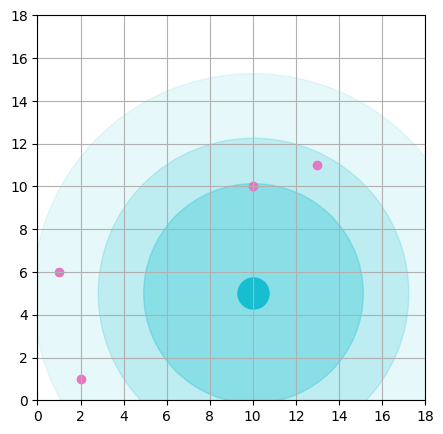

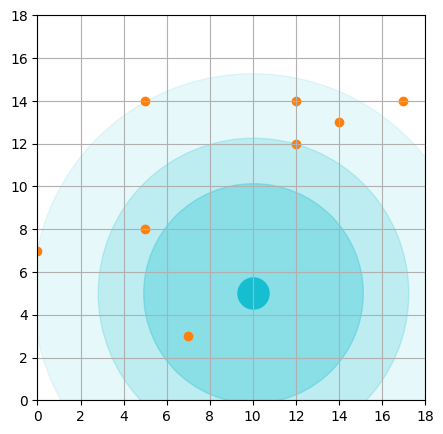

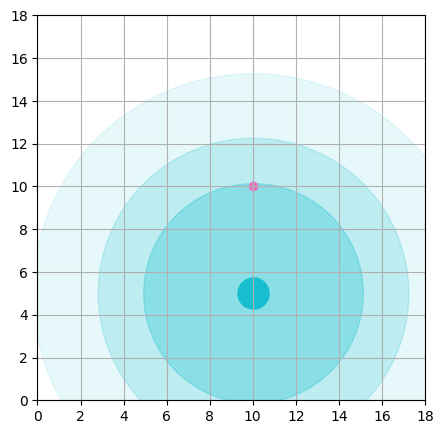

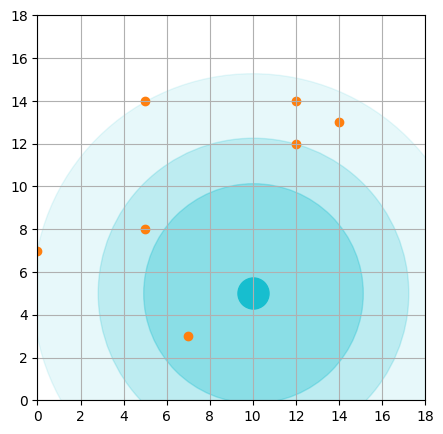

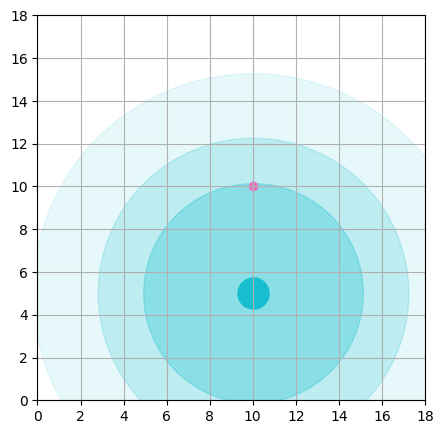

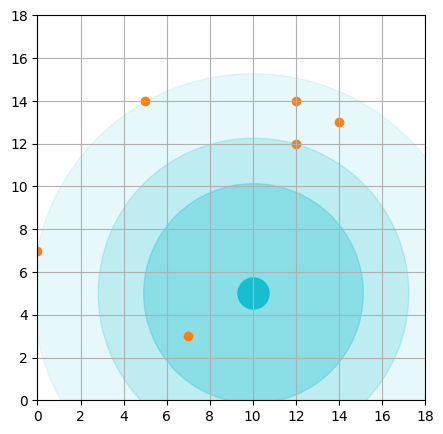

In [19]:
if True:
    
    # =============================================================================
    # train model and run test/xAI routine

    # logger - save logs in "examples/example_results/lightning_logs"
    # light - DecentLightning model
    # trainer - pl.Trainer
    # trainer.fit
    # explainer - pl.Trainer
    # explainer.test
    # =============================================================================

    pl.seed_everything(19) # To be reproducable
    train_kwargs["load_ckpt_file"] = "" # needed

    # THE LOGGER
    logger = CSVLogger(os.path.join(train_kwargs["result_path"], 'lightning_logs'), name=train_kwargs["exp_name"])

    # THE LIGHTNING MODEL
    # Initialize the LightningModule
    light = DecentLightning(kwargs=kwargs, log_dir=logger.log_dir)

    # THE LIGHTNING TRAINER (for training)
    trainer = pl.Trainer(default_root_dir=train_kwargs["result_path"],
                         accelerator="gpu" if str(train_kwargs["device"]).startswith("cuda") else "cpu",
                         devices=[0],
                         # inference_mode=False, # do grad manually
                         log_every_n_steps=train_kwargs["log_every_n_steps"],
                         logger=logger,
                         check_val_every_n_epoch=1,
                         max_epochs=train_kwargs["epochs"],
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_f1",
                                                   filename='{epoch}-{val_f1:.2f}-{unpruned:.0f}'),
                                    DecentModelCheckpoint(save_weights_only=True, mode="min", monitor="unpruned", save_top_k=-1, save_on_train_epoch_end=True,
                                                    filename='{epoch}-{unpruned:.0f}-{val_f1:.2f}'),
                                    LearningRateMonitor("epoch")])

    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # THE TRAIN-RUN
    # Train the model using a Trainer
    trainer.fit(light, data.train_dataloader, data.val_dataloader)
    

    # THE LIGHTNING TRAINER (for testing)
    # we want the grad to work in test, hence: inference_mode=False
    explainer = pl.Trainer(default_root_dir=train_kwargs["result_path"],
                         accelerator="gpu" if str(train_kwargs["device"]).startswith("cuda") else "cpu",
                         devices=[0],
                         logger=logger,
                         inference_mode=False)

    # THE TEST-RUN
    # including test
    test_result = explainer.test(light, data.xai_dataloader, verbose=False)

    print("Done")

## run test routine ****************************

torch.load(ckpt_path)['state_dict']

In [21]:
if True:

    # =============================================================================
    # load model and run test/xAI routine

    # logger - save logs in "dumpster"
    # light - DecentLightning model
    # explainer - pl.Trainer
    # explainer.test
    # =============================================================================

    pl.seed_everything(19) # To be reproducable
    
    # Check whether pretrained model exists. If yes, load it.
    # ckpt_path = os.path.join(*[train_kwargs["result_path"], "lightning_logs\debug_oct_no_fc", 'version_13', 'checkpoints/epoch=2-unpruned=269-val_f1=0.25.ckpt'])
    ckpt_path = os.path.join(*[train_kwargs["result_path"], "lightning_logs", train_kwargs["exp_name"], train_kwargs["load_ckpt_file"]])
    print(ckpt_path)
    
    if os.path.isfile(ckpt_path):

        # THE LOGGER
        logger = CSVLogger(os.path.join(train_kwargs["result_path"], 'lightning_logs'), name='dumpster')

        # THE LIGHTNING MODEL
        # load from checkpoint doesn't work, since our architecture is 'messed up' through pruning
        # light = DecentLightning.load_from_checkpoint(state_dict, model_kwargs=model_kwargs, log_dir="example_results/lightning_logs") # Automatically loads the model with the saved hyperparameters
        # use this line instead:
        light = DecentLightning(kwargs=kwargs, log_dir=logger.log_dir)

        # THE LIGHTNING TRAINER (for testing)
        # we want the grad to work in test, hence: inference_mode=False
        explainer = pl.Trainer(default_root_dir=train_kwargs["result_path"],
                             accelerator="gpu" if str(train_kwargs["device"]).startswith("cuda") else "cpu",
                             #devices=[0],
                             logger=logger,
                             inference_mode=False)

        # THE TEST-RUN
        # only test
        test_result = explainer.test(light, data.xai_dataloader, verbose=False)

    else:
        print('DECENT ERROR: not a dir - may have been resetted in dev routine, check the load_ckpt_file, set dev routine to False and run everything')
        print('current load_ckpt_file is:', train_kwargs["load_ckpt_file"])

    
    print("Done")


Seed set to 19


examples/example_results\lightning_logs\debug_retinamnist_no_fc\
DECENT ERROR: not a dir - may have been resetted in dev routine, check the load_ckpt_file, set dev routine to False and run everything
current load_ckpt_file is: 
Done


# random nonsense

In [ ]:
light.model

In [ ]:
for a in light.model.decent3.filter_list:
    print(a.weights)